In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tqdm import tqdm, tqdm_notebook
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import pearsonr, spearmanr, kendalltau


Data Cleaning

In [3]:
data_path = "Data"
csv_files = [f for f in os.listdir(data_path) if f.endswith("-usd-max.csv")]


def merge_csv_files(files, folder):
    data_frames = []

    for file in files:
        # Read CSV file
        file_path = os.path.join(folder, file)
        data_frame = pd.read_csv(file_path)

        # Extract ticker from file name
        ticker = file.split("-")[0]

        # Rename price column to the corresponding ticker
        data_frame = data_frame.rename(columns={"price": ticker})

        # Drop unnecessary columns
        data_frame = data_frame.drop(columns=["market_cap", "total_volume"])

        # Convert "snapped_at" column to datetime format
        data_frame["snapped_at"] = pd.to_datetime(data_frame["snapped_at"])

        # Set "snapped_at" as the index
        data_frame = data_frame.set_index("snapped_at")

        # Append the processed data frame to the list
        data_frames.append(data_frame)

    # Merge all data frames using the index
    merged_data = pd.concat(data_frames, axis=1, join="outer")

    return merged_data

merged_data_frame = merge_csv_files(csv_files, data_path)

Drop values before 2020-01-01

In [4]:
# Filter the merged_data_frame to keep data from 2020 onwards
filtered_data_frame = merged_data_frame[merged_data_frame.index.year >= 2020]
# drop columns with not enough data
filtered_data_frame.drop(columns=["shib"], inplace=True)
output_file_filtered = "filtered_data.csv"
filtered_data_frame.to_csv(output_file_filtered)


C:\Users\thoma\AppData\Local\Temp\ipykernel_32220\3556428997.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_frame.drop(columns=["shib"], inplace=True)


Data Exploration

In [5]:
filtered_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1225 entries, 2020-01-01 00:00:00+00:00 to 2023-05-09 00:00:00+00:00
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ada     1223 non-null   float64
 1   ar      1224 non-null   float64
 2   atom    1225 non-null   float64
 3   bat     1225 non-null   float64
 4   bch     1225 non-null   float64
 5   bnb     1224 non-null   float64
 6   btc     1223 non-null   float64
 7   busd    1223 non-null   float64
 8   cro     1225 non-null   float64
 9   dai     1225 non-null   float64
 10  dash    1224 non-null   float64
 11  dgb     1225 non-null   float64
 12  doge    1223 non-null   float64
 13  etc     1224 non-null   float64
 14  eth     1223 non-null   float64
 15  ftm     1225 non-null   float64
 16  kcs     1225 non-null   float64
 17  leo     1223 non-null   float64
 18  link    1224 non-null   float64
 19  mana    1224 non-null   float64
 20  mkr     1225 non-null   fl

In [6]:
filtered_data_frame.head()

,ada,ar,atom,bat,bch,bnb,btc,busd,cro,dai,...,omg,qtum,snx,usdc,usdt,xlm,xmr,xrp,zec,zil
snapped_at,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,0.032912,0.813411,4.219579,0.180870,204.561792,13.716391,7195.153895,1.002401,0.033641,0.981847,...,0.606727,1.609848,1.205578,1.003172,0.999366,0.045042,44.586492,0.192993,27.529298,0.004452
2020-01-02 00:00:00+00:00,0.033362,0.696112,4.381528,0.194672,204.348311,13.685902,7193.754668,1.002661,0.033955,0.972606,...,0.616387,1.599572,1.209918,1.003346,0.999508,0.045311,45.780578,0.192556,28.046206,0.004503
2020-01-03 00:00:00+00:00,0.032618,0.664268,4.098819,0.182523,195.674640,13.007171,6963.853354,1.001653,0.032891,0.978826,...,0.593536,1.532726,1.114260,1.002434,0.999983,0.043735,45.342985,0.187433,27.029583,0.004354
2020-01-04 00:00:00+00:00,0.033967,0.677890,4.227682,0.186174,221.621452,13.603276,7300.346935,1.001195,0.034394,0.987877,...,0.625430,1.624714,1.161237,1.000130,0.998661,0.045609,50.851224,0.192299,28.448989,0.004474
2020-01-05 00:00:00+00:00,0.034298,0.665807,4.253197,0.188094,224.487505,13.794575,7351.377053,1.001829,0.034388,0.970134,...,0.625897,1.638943,1.140031,1.001133,0.999595,0.045703,50.294998,0.192812,29.934325,0.004557


In [7]:
# Check for missing values
filtered_data_frame.isnull().sum()

ada     2
ar      1
atom    0
bat     0
bch     0
bnb     1
btc     2
busd    2
cro     0
dai     0
dash    1
dgb     0
doge    2
etc     1
eth     2
ftm     0
kcs     0
leo     2
link    1
mana    1
mkr     0
mnw     1
omg     1
qtum    1
snx     0
usdc    0
usdt    2
xlm     1
xmr     1
xrp     2
zec     0
zil     0
dtype: int64

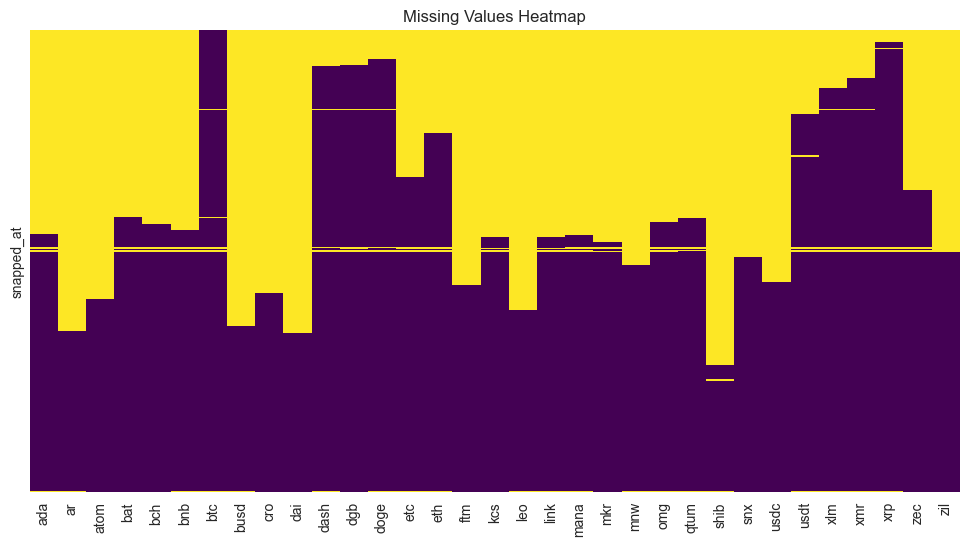

In [8]:
#Viusalize the missing data before cutoff
plt.figure(figsize=(12, 6))
sns.heatmap(merged_data_frame.isna(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

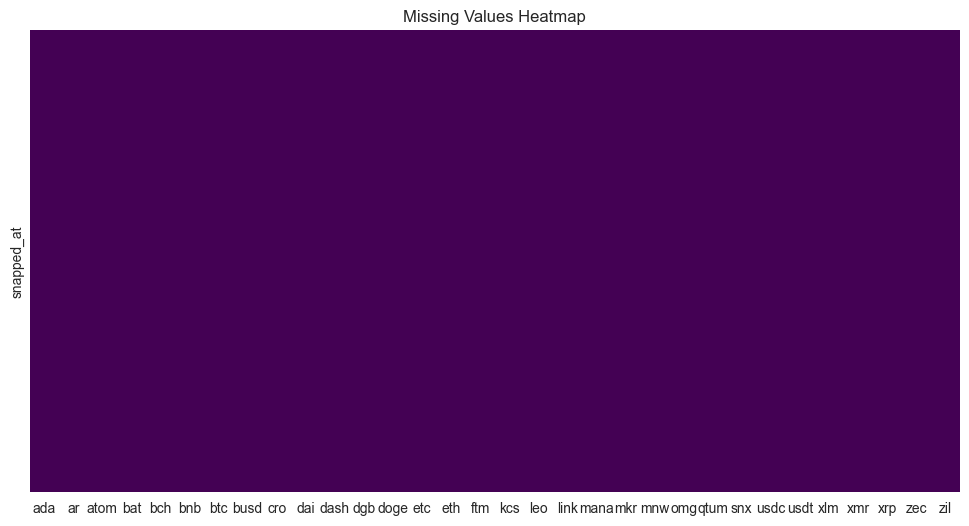

In [9]:
#Viusalize the missing data after cutoff
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_data_frame.isna(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [10]:
filtered_data_frame.columns

Index(['ada', 'ar', 'atom', 'bat', 'bch', 'bnb', 'btc', 'busd', 'cro', 'dai',
       'dash', 'dgb', 'doge', 'etc', 'eth', 'ftm', 'kcs', 'leo', 'link',
       'mana', 'mkr', 'mnw', 'omg', 'qtum', 'snx', 'usdc', 'usdt', 'xlm',
       'xmr', 'xrp', 'zec', 'zil'],
      dtype='object')

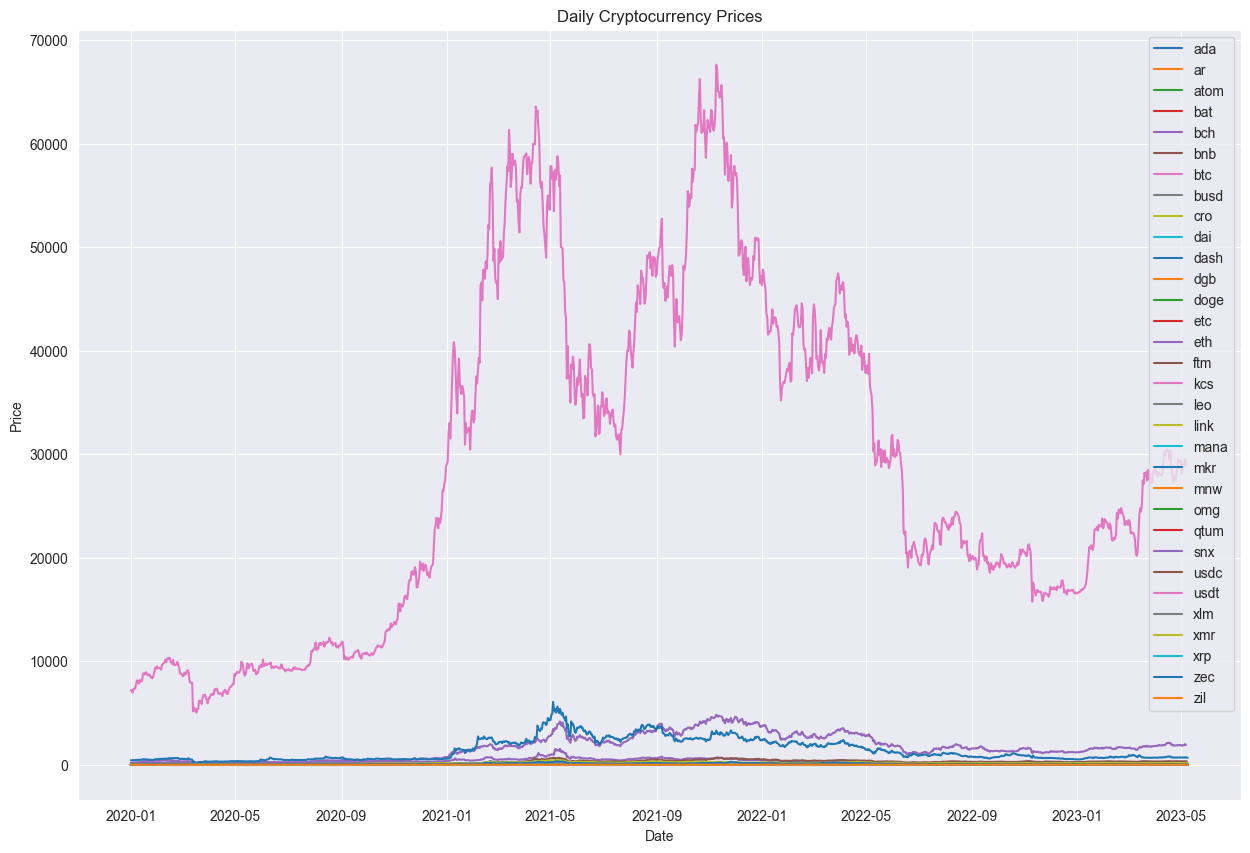

In [11]:
# plot price data
# Extract the prices columns from the dataframe
prices = filtered_data_frame.copy()

# Plot the prices on the same chart
plt.figure(figsize=(15,10)) # Set the size of the figure
plt.plot(prices) # Plot the prices
plt.legend(prices.columns) # Add a legend with the column names as labels
plt.title('Daily Cryptocurrency Prices') # Add a title to the chart
plt.xlabel('Date') # Add a label to the x-axis
plt.ylabel('Price') # Add a label to the y-axis
plt.show() # Show the chart


In [12]:
# Calculate daily returns
daily_returns = filtered_data_frame.pct_change().dropna()
daily_returns.head()



,ada,ar,atom,bat,bch,bnb,btc,busd,cro,dai,...,omg,qtum,snx,usdc,usdt,xlm,xmr,xrp,zec,zil
snapped_at,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,0.013675,-0.144206,0.038380,0.076306,-0.001044,-0.002223,-0.000194,0.000259,0.009345,-0.009412,...,0.015922,-0.006383,0.003600,0.000173,0.000141,0.005971,0.026781,-0.002268,0.018777,0.011438
2020-01-03 00:00:00+00:00,-0.022305,-0.045746,-0.064523,-0.062406,-0.042446,-0.049594,-0.031958,-0.001005,-0.031330,0.006396,...,-0.037073,-0.041790,-0.079061,-0.000910,0.000476,-0.034779,-0.009559,-0.026601,-0.036248,-0.033009
2020-01-04 00:00:00+00:00,0.041374,0.020507,0.031439,0.020000,0.132602,0.045829,0.048320,-0.000458,0.045687,0.009247,...,0.053736,0.060016,0.042160,-0.002298,-0.001322,0.042852,0.121479,0.025960,0.052513,0.027649
2020-01-05 00:00:00+00:00,0.009743,-0.017824,0.006035,0.010313,0.012932,0.014063,0.006990,0.000634,-0.000157,-0.017961,...,0.000746,0.008758,-0.018261,0.001003,0.000935,0.002055,-0.010938,0.002665,0.052211,0.018342
2020-01-06 00:00:00+00:00,0.003751,-0.012317,-0.012698,-0.007883,-0.008120,0.015353,-0.000191,-0.001682,0.000536,0.011305,...,0.013789,-0.008135,-0.011628,-0.000632,-0.000522,-0.007782,0.065704,0.005207,0.025485,0.004308


In [13]:
daily_returns.describe()

,ada,ar,atom,bat,bch,bnb,btc,busd,cro,dai,...,omg,qtum,snx,usdc,usdt,xlm,xmr,xrp,zec,zil
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,...,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,0.003543,0.005362,0.002970,0.002028,0.001030,0.004041,0.001823,0.000007,0.002111,0.000024,...,0.002984,0.002521,0.003402,0.000002,0.000006,0.002141,0.002304,0.002495,0.001987,0.004048
std,0.055602,0.086642,0.066182,0.061836,0.055239,0.054907,0.036662,0.004014,0.055927,0.004179,...,0.073246,0.064594,0.076988,0.002917,0.002755,0.057196,0.049753,0.060526,0.060012,0.075676
min,-0.408091,-0.391487,-0.462426,-0.448228,-0.440029,-0.428239,-0.351903,-0.062881,-0.399675,-0.034374,...,-0.447328,-0.452397,-0.461524,-0.028088,-0.019535,-0.355552,-0.400701,-0.422790,-0.405578,-0.445706
25%,-0.025859,-0.040188,-0.031457,-0.027258,-0.023398,-0.017571,-0.014367,-0.001217,-0.022362,-0.001465,...,-0.031795,-0.026701,-0.042719,-0.001168,-0.001014,-0.024066,-0.020904,-0.021987,-0.027567,-0.031943
50%,0.001108,-0.004616,0.001550,0.000006,0.001730,0.002254,0.000992,0.000000,0.002606,0.000082,...,0.001122,0.003331,-0.000892,0.000051,0.000026,0.001665,0.003479,0.000701,0.002296,0.002065
75%,0.028013,0.039459,0.034851,0.030774,0.024279,0.025096,0.018731,0.001264,0.025465,0.001472,...,0.034880,0.032120,0.042140,0.001183,0.001015,0.024211,0.027323,0.023533,0.032365,0.034063
max,0.308911,0.576601,0.325721,0.476045,0.526698,0.737863,0.192470,0.067199,0.577011,0.028686,...,0.705055,0.480128,0.584248,0.029080,0.025320,0.742053,0.374062,0.527074,0.272347,0.887106


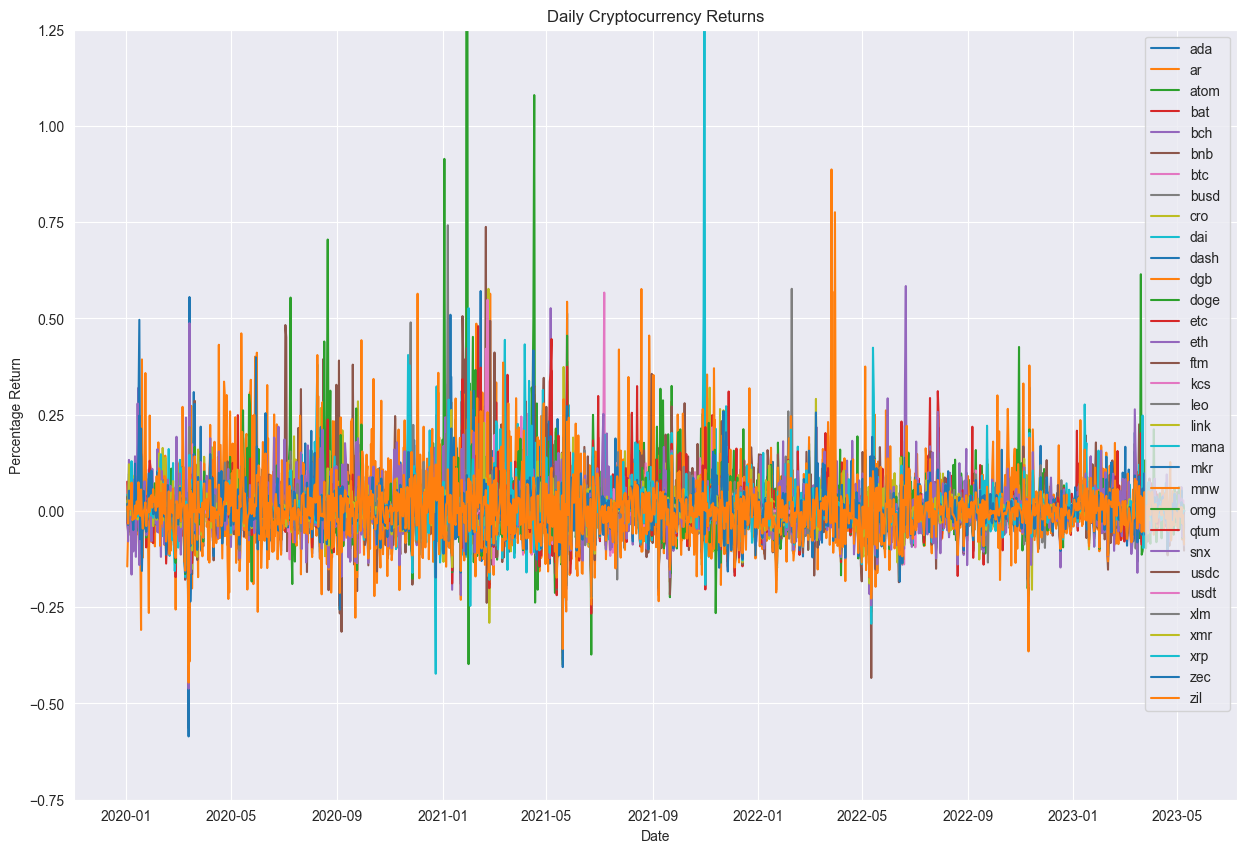

In [14]:
# Plot the returns on the same chart
plt.figure(figsize=(15,10)) # Set the size of the figure
plt.plot(daily_returns) # Plot the returns
plt.legend(daily_returns.columns) # Add a legend with the column names as labels
plt.title('Daily Cryptocurrency Returns') # Add a title to the chart
plt.xlabel('Date') # Add a label to the x-axis
plt.ylabel('Percentage Return') # Add a label to the y-axis
plt.ylim(-0.75, 1.25) # Adjust the y-axis scale
plt.show() # Show the chart

In [15]:
# Function to show dataframe structure
def print_dataframe_structure(dataframe):
    print("Index data type: ", dataframe.index.dtype)
    print("Column structure: ", dataframe.columns)
    print("Shape of the DataFrame: ", dataframe.shape)
    print("Data types of columns: \n", dataframe.dtypes)
    print("Number of missing values: ", dataframe.isna().sum().sum())

Market Condition Classification

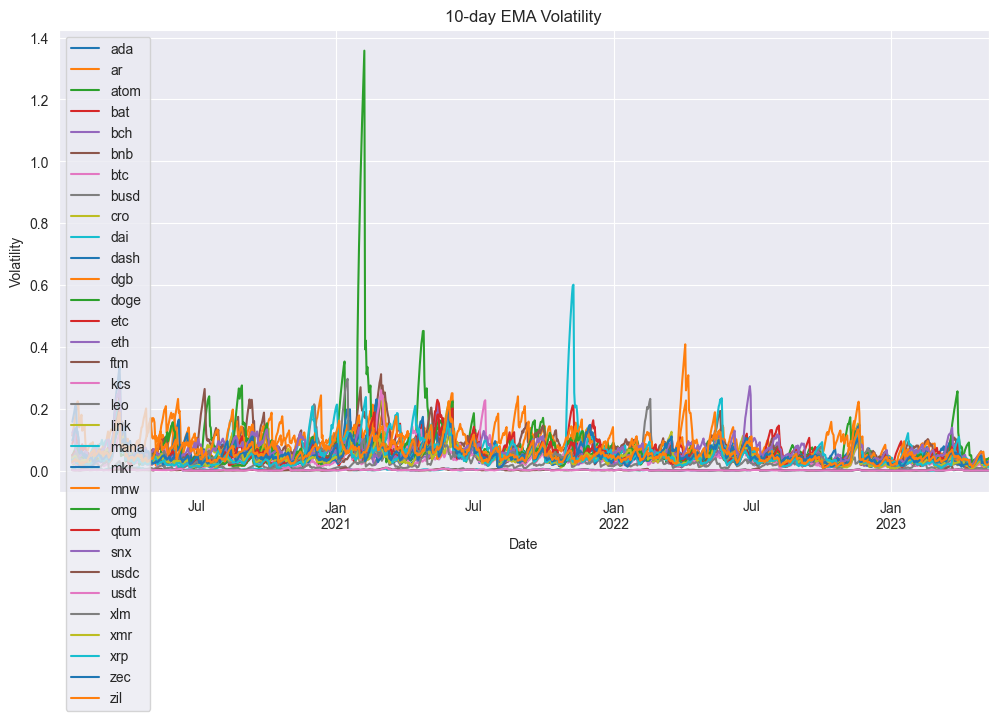

,ada,ar,atom,bat,bch,bnb,btc,busd,cro,dai,...,omg,qtum,snx,usdc,usdt,xlm,xmr,xrp,zec,zil
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,...,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,0.046501,0.072634,0.056152,0.051041,0.043927,0.041042,0.031111,0.002602,0.044253,0.003011,...,0.059008,0.052875,0.066375,0.002217,0.002094,0.044681,0.040862,0.045690,0.051369,0.059914
std,0.024245,0.038917,0.028921,0.029449,0.028242,0.031536,0.015440,0.002857,0.028580,0.002498,...,0.037005,0.030899,0.031450,0.001714,0.001635,0.030970,0.024092,0.034292,0.025649,0.039408
min,0.008405,0.016665,0.009362,0.013452,0.010286,0.005614,0.004587,0.000288,0.009511,0.000301,...,0.011767,0.011675,0.011485,0.000227,0.000251,0.008949,0.007011,0.008048,0.010547,0.008842
25%,0.030090,0.044870,0.035476,0.032594,0.026510,0.023800,0.020773,0.001269,0.026124,0.001506,...,0.036041,0.033075,0.047363,0.001124,0.000963,0.027171,0.026499,0.023767,0.035447,0.036850
50%,0.040975,0.063672,0.049951,0.042404,0.036202,0.032877,0.028348,0.002016,0.037777,0.002326,...,0.049198,0.045274,0.061096,0.001796,0.001707,0.037651,0.035758,0.034752,0.045640,0.050947
75%,0.056195,0.087865,0.069737,0.060565,0.051473,0.047138,0.038064,0.003111,0.052700,0.003710,...,0.070616,0.063780,0.077910,0.002673,0.002724,0.051776,0.048022,0.053603,0.060410,0.071289
max,0.187109,0.246987,0.197112,0.211008,0.213665,0.311927,0.150410,0.036297,0.259083,0.020840,...,0.275686,0.215232,0.273433,0.016152,0.013327,0.297042,0.222281,0.238285,0.209813,0.408535


In [16]:
# Calculate Exponential moving standard deviation
def emsd(data, time_window):
    ema_weights = np.arange(1, time_window + 1)
    ema_weights = ema_weights[::-1]  # Reverse the array
    ema_weights = ema_weights / ema_weights.sum()  # Normalize the weights

    squared_diff = (data - data.rolling(window=time_window).mean()) ** 2
    emsd_values = squared_diff.rolling(window=time_window).apply(lambda x: np.sum(ema_weights * x))

    return np.sqrt(emsd_values)

time_window = 10
ema_volatility = emsd(daily_returns, time_window)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the EMA Volatility for each asset
for column in ema_volatility.columns:
    ema_volatility[column].plot(ax=ax, label=column)

# Add labels and a legend
ax.set_title('10-day EMA Volatility')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.legend(loc='upper left')

# Show the plot
plt.show()
ema_volatility.describe()

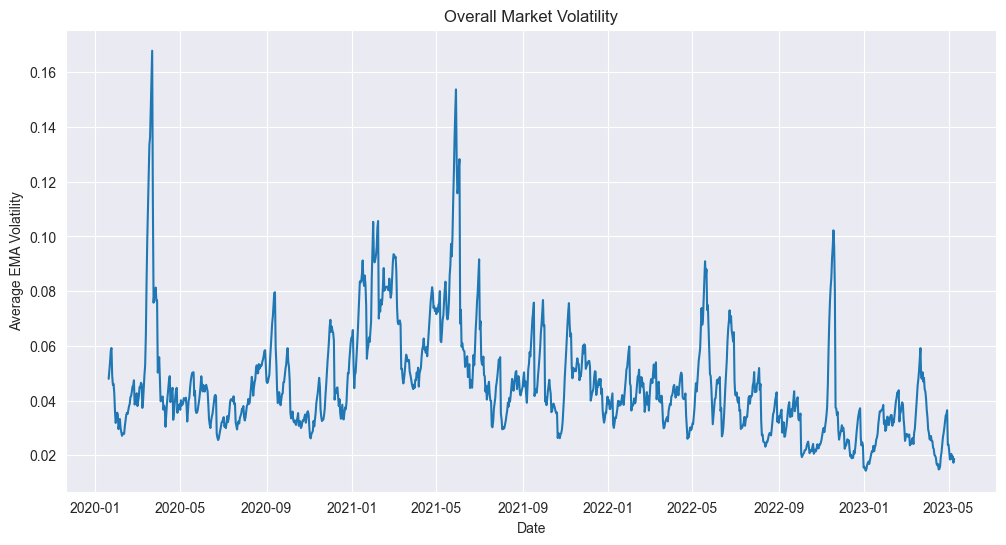

In [17]:
# Calculate the average EMA volatility for each day across all cryptocurrencies
ema_volatility['average_volatility'] = ema_volatility.mean(axis=1)

# Create a new DataFrame to store the aggregated EMA volatility
agg_ema_volatility = ema_volatility[['average_volatility']]

# Plot the overall market volatility on a graph
plt.figure(figsize=(12, 6))
plt.plot(agg_ema_volatility.index, agg_ema_volatility['average_volatility'])
plt.xlabel('Date')
plt.ylabel('Average EMA Volatility')
plt.title('Overall Market Volatility')
plt.show()

In [45]:
# Establish thresholds using standard deviation bands
mean_volatility = np.mean(agg_ema_volatility['average_volatility'])
std_volatility = np.std(agg_ema_volatility['average_volatility'])
low_volatility_threshold = mean_volatility - std_volatility
high_volatility_threshold = mean_volatility + std_volatility

# Classify the market conditions
def classify_market_condition(volatility, low_threshold, high_threshold):
    low_threshold_arr = np.full_like(volatility, low_threshold, dtype=float)
    high_threshold_arr = np.full_like(volatility, high_threshold, dtype=float)

    conditions = np.full_like(volatility, "medium_volatility", dtype=object)
    conditions[volatility < low_threshold_arr] = "low_volatility"
    conditions[volatility > high_threshold_arr] = "high_volatility"
    return conditions

market_conditions = classify_market_condition(
    agg_ema_volatility['average_volatility'].values,
    low_volatility_threshold,
    high_volatility_threshold
)

agg_ema_volatility.loc[:, 'market_condition'] = market_conditions


,average_volatility,market_condition
snapped_at,,
2020-01-02 00:00:00+00:00,NaN,medium_volatility
2020-01-03 00:00:00+00:00,NaN,medium_volatility
2020-01-04 00:00:00+00:00,NaN,medium_volatility
2020-01-05 00:00:00+00:00,NaN,medium_volatility
2020-01-06 00:00:00+00:00,NaN,medium_volatility


Correlation Analysis

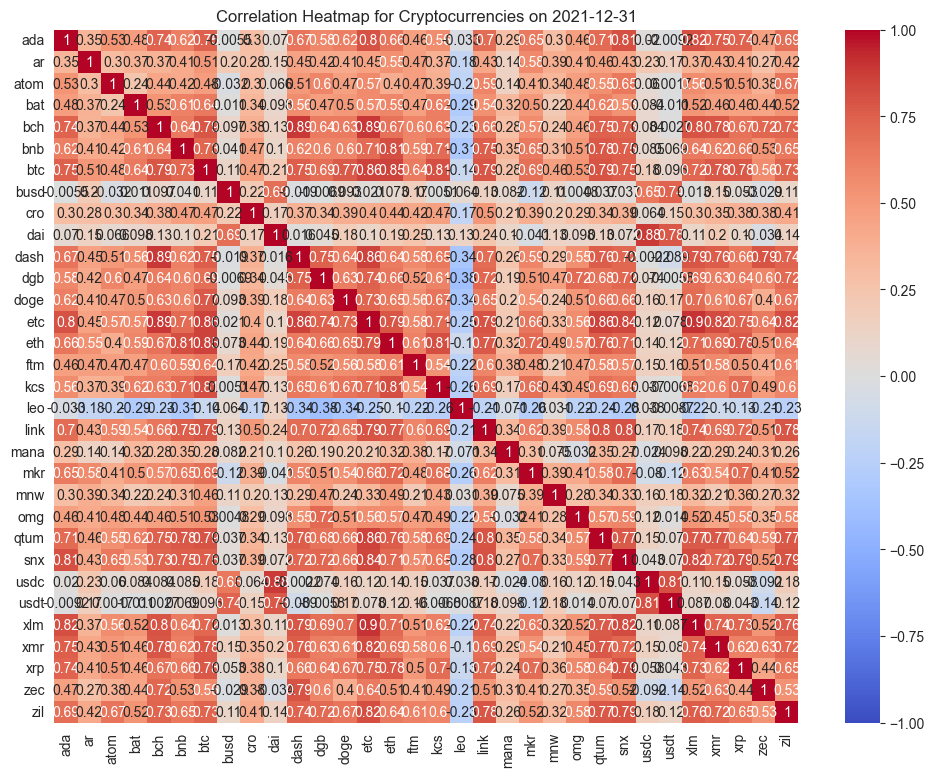

In [145]:
# Calculate rolling correlations
window_size = 60
rolling_corr = daily_returns.rolling(window=window_size).corr().dropna()

# Generate heatmap of rolling correlation matrix
def gen_heatmap(data, date):
    correlation_matrix = data.loc[date]
    # Create a correlation heatmap
    plt.figure(figsize=(12, 9))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for Cryptocurrencies on {date}')
    plt.show()


gen_heatmap(rolling_corr, '2021-12-31')


In [ ]:
def create_correlation_matrix_optimized(rolling_correlation):
    # Create a multi-level index DataFrame with snapped_at and level_1 as the index
    rolling_correlation_midx = rolling_correlation.set_index(['snapped_at', 'level_1'])

    # Drop 'snapped_at' and 'level_1' columns and stack the remaining columns
    stacked_rolling_correlation = rolling_correlation_midx.drop(columns=['snapped_at', 'level_1']).stack().reset_index()

    # Rename the columns for clarity
    stacked_rolling_correlation.columns = ['date', 'crypto1', 'crypto2', 'correlation']

    # Create a progress bar
    progress_bar = tqdm(total=len(rolling_correlation), desc='Creating correlation matrix')

    def calculate_correlation(row):
        progress_bar.update(1)
        return row.pivot_table(index=['crypto1', 'date'], columns='crypto2', values='correlation')

    # Create a correlation matrix using pivot_table() with progress bar updates
    correlation_matrix = stacked_rolling_correlation.groupby('date').progress_apply(calculate_correlation)

    progress_bar.close()

    return correlation_matrix

# correlation_matrix_wide = create_correlation_matrix_optimized(rolling_corr)
# correlation_matrix_wide

# # Create a custom animated heatmap using plotly.graph_objects
def create_heatmap(date):
    correlation_data = correlation_matrix_wide.loc[:, date]
    correlation_data_square = correlation_data.pivot_table(index='crypto', columns='level_1', values=0)
    heatmap = go.Heatmap(x=cryptos, y=cryptos, z=correlation_data_square, colorscale='RdBu_r', zmin=-1, zmax=1, showscale=False)
    return heatmap

# # Create a custom animated heatmap using plotly.graph_objects
# fig = go.Figure()
#
# # Get the list of unique dates and cryptocurrencies
# dates = rolling_corr.index.unique()
# cryptos = rolling_corr['level_1'].unique()
#
# # Create a heatmap for each date using parallel processing
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     heatmaps = list(tqdm(executor.map(create_heatmap, dates), total=len(dates)))
#
# # Add heatmaps to the figure
# fig.add_traces(heatmaps)
#
# # Set up the animation settings
# animation_settings = dict(frame=dict(duration=500, redraw=True), fromcurrent=True, showlegend=False)
#
# # Customize the appearance of the heatmap
# fig.update_layout(title='Animated Correlation Heatmap for Cryptocurrencies',
#                   xaxis_title='Crypto1',
#                   yaxis_title='Crypto2',
#                   width=800,
#                   height=800,
#                   updatemenus=[dict(type='buttons', showactive=False, buttons=[dict(label='Play', method='animate', args=[None, animation_settings])])])
#
# # Display the animated heatmap
# fig.show()

print_dataframe_structure(rolling_corr)

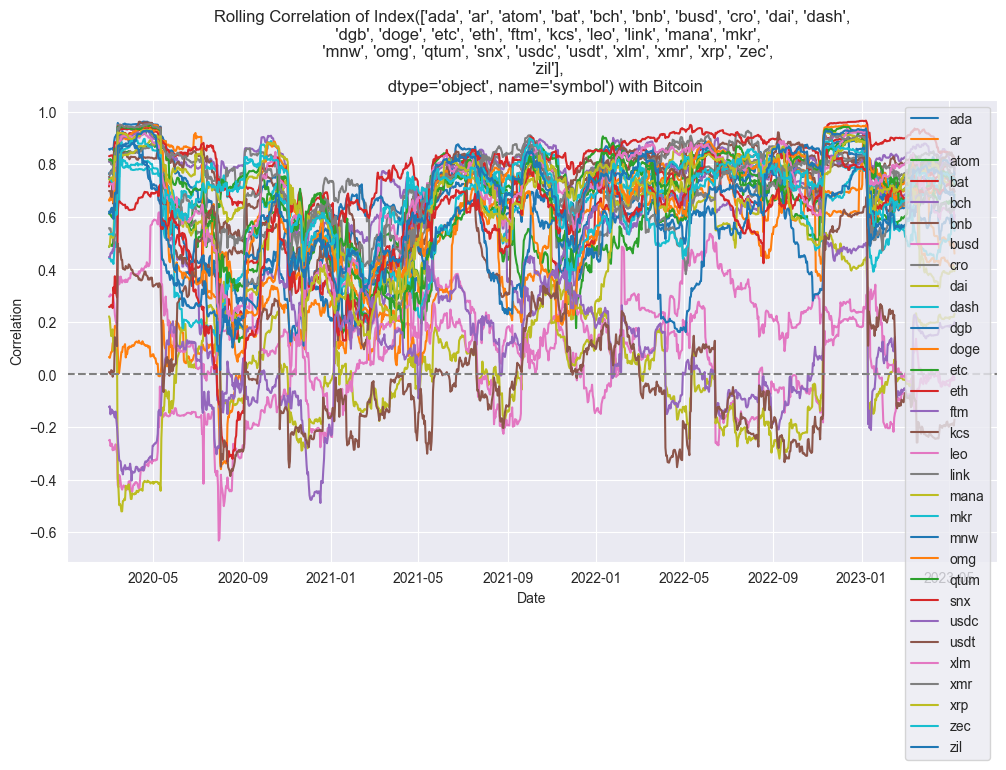

In [144]:
def get_correlation_df(ticker='btc'):
    # Convert the series to a DataFrame
    corr_df = rolling_corr[ticker].reset_index()

    # Rename the columns to be more descriptive
    corr_df.columns = ['snapped_at', 'symbol', 'correlation']

    # Pivot the DataFrame to get the desired format
    pivoted_corr_df = corr_df.pivot(index='snapped_at', columns='symbol', values='correlation')

    # Drop the ticker itself from the columns
    pivoted_corr_df.drop(ticker, axis=1, inplace=True)
    return pivoted_corr_df


btc_corr = get_correlation_df('btc')


def plot_correlation_line(dataframe, symbol):
    # Filter the DataFrame to get the data for the given symbol
    corr_data = dataframe[symbol]

    # Plot the correlation data
    plt.figure(figsize=(12, 6))
    plt.plot(corr_data, label=symbol)
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.title(f'Rolling Correlation of {symbol} with Bitcoin')
    # Add a horizontal line at y=0
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    plt.show()

# Call the function with the pivoted_corr_df DataFrame and the symbol you want to plot
plot_correlation_line(btc_corr, btc_corr.columns)

symbol,ada,ar,atom,bat,bch,bnb,btc,busd,cro,dai,...,omg,qtum,snx,usdc,usdt,xlm,xmr,xrp,zec,zil
snapped_at,,,,,,,,,,,,,,,,,,,,,
2020-03-01 00:00:00+00:00,0.858067,0.066725,0.485738,0.715289,0.809422,0.751752,1.0,-0.250606,0.812180,0.221160,...,0.666199,0.817962,0.257285,-0.123237,0.008866,0.724343,0.761797,0.741993,0.533475,0.614303
2020-03-02 00:00:00+00:00,0.855208,0.063384,0.490640,0.734858,0.808816,0.750159,1.0,-0.248824,0.811999,0.212204,...,0.666887,0.817958,0.256427,-0.121018,0.007659,0.723826,0.761857,0.741782,0.533847,0.614594
2020-03-03 00:00:00+00:00,0.859173,0.075343,0.496095,0.735186,0.810542,0.747181,1.0,-0.272467,0.811962,0.175620,...,0.670166,0.819372,0.261188,-0.151714,0.001109,0.725711,0.771699,0.744245,0.533632,0.615363
2020-03-04 00:00:00+00:00,0.859192,0.085296,0.492764,0.744087,0.802115,0.744794,1.0,-0.263550,0.799741,0.146149,...,0.664754,0.814767,0.264658,-0.132947,0.016308,0.724367,0.763778,0.749375,0.534222,0.621601
2020-03-05 00:00:00+00:00,0.859170,0.086550,0.488920,0.739679,0.800888,0.743240,1.0,-0.264068,0.800892,0.163672,...,0.665222,0.814791,0.265003,-0.134348,0.014579,0.724519,0.765666,0.749620,0.534618,0.621418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-05 00:00:00+00:00,0.693178,0.728476,0.655831,0.791956,0.811530,0.703248,1.0,-0.021246,0.765025,0.218562,...,0.412724,0.734980,0.749204,0.185321,-0.191218,0.620632,0.617562,0.391735,0.745612,0.685103
2023-05-06 00:00:00+00:00,0.694933,0.731259,0.658368,0.794952,0.813455,0.703281,1.0,-0.022733,0.758906,0.218031,...,0.412149,0.740422,0.751498,0.184824,-0.186414,0.621794,0.631611,0.392191,0.748643,0.684710
2023-05-07 00:00:00+00:00,0.700270,0.734060,0.661862,0.797768,0.815340,0.707446,1.0,-0.019257,0.761868,0.219949,...,0.416943,0.741632,0.754994,0.186258,-0.186511,0.624512,0.631807,0.401115,0.751047,0.686848
